<a href="https://colab.research.google.com/github/RolandTapie/Data_Projects/blob/main/Data_science/Bank/Bank_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import des librairies**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import nxviz as nv


from scipy.stats import iqr
from sklearn.metrics import mean_squared_error, r2_score,roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
import seaborn as sns
import statsmodels.api as sm
import numpy as np

from google.colab import drive

**Montage du drive**

In [ ]:
# Monter Google Drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [ ]:
# Chemin vers le fichier dans Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/Bank/bank_cleaned.csv'
cible = "response"
feat=['age', 'job', 'marital', 'education', 'default','balance', 'housing', 'loan', 'day', 'month', 'duration', 'campaign','pdays', 'previous', 'poutcome', 'response_binary']
feat=['age', 'balance','duration', 'campaign','pdays','loan']
one_hot_enconding=["job","marital","education","default","housing","loan","month","poutcome"]
one_hot_enconding=['loan']


**Lecture du dataset**

In [ ]:
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40841 entries, 0 to 40840
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       40841 non-null  int64  
 1   age              40841 non-null  int64  
 2   job              40841 non-null  object 
 3   marital          40841 non-null  object 
 4   education        40841 non-null  object 
 5   default          40841 non-null  object 
 6   balance          40841 non-null  int64  
 7   housing          40841 non-null  object 
 8   loan             40841 non-null  object 
 9   day              40841 non-null  int64  
 10  month            40841 non-null  object 
 11  duration         40841 non-null  float64
 12  campaign         40841 non-null  int64  
 13  pdays            40841 non-null  int64  
 14  previous         40841 non-null  int64  
 15  poutcome         40841 non-null  object 
 16  response         40841 non-null  object 
 17  response_bin

**Vérification des enrigistrements nulls**

In [ ]:
df = pd.read_csv(file_path)

In [ ]:
df.isna().any()
df.isnull().any()

,0
Unnamed: 0,False
age,False
job,False
marital,False
education,False
default,False
balance,False
housing,False
loan,False
day,False


In [ ]:

df=df.drop("Unnamed: 0",axis=1)
mapping = {'no': 0, 'yes': 1)
colonnes=df.columns.tolist()
liste=[]
print(colonnes)
for col in colonnes:
  if df[col].dtype=="object":
    df[col]=df[col].astype("category")
    print(col)
    print(df[col].unique())
    print('\n')

  if (df[col].dtype=="int64") | (df[col].dtype=="float64") :
    liste.append(col)
print (liste)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'response', 'response_binary']
job
['management', 'technician', 'entrepreneur', 'retired', 'admin.', ..., 'self-employed', 'unemployed', 'housemaid', 'student', 'other']
Length: 12
Categories (12, object): ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', ..., 'services',
                          'student', 'technician', 'unemployed']


marital
['married', 'single', 'divorced']
Categories (3, object): ['divorced', 'married', 'single']


education
['tertiary', 'secondary', 'primary']
Categories (3, object): ['primary', 'secondary', 'tertiary']


default
['no', 'yes']
Categories (2, object): ['no', 'yes']


housing
['yes', 'no']
Categories (2, object): ['no', 'yes']


loan
['no', 'yes']
Categories (2, object): ['no', 'yes']


month
['may', 'jun', 'jul', 'aug', 'oct', ..., 'jan', 'feb', 'mar', 'apr', 'sep']
Length: 12
Categories (12

## **Vérifications des distributions**

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'response_binary'}>, <Axes: >]],
      dtype=object)

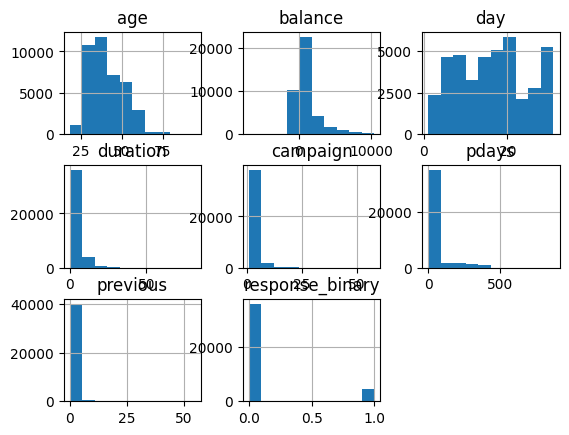

In [ ]:
df[liste].hist()

Détection des valeurs abérantes

In [ ]:
df_corr=df[liste]
df_corr.describe()
for col in liste:
  print(col)
  print(iqr(df_corr[col]))

age
15.0
balance
1269.0
day
13.0
duration
3.57
campaign
2.0
pdays
0.0
previous
0.0
response_binary
0.0


In [ ]:
for col in liste:
  print(col)
  plt.figure(figsize=(10,5))
  plt.boxplot(df[col])
  plt.show()

**Vérification des Corrélations**

       age  balance  day  duration  campaign  pdays  previous  response_binary
0       58     2143    5      4.35         1     -1         0                0
1       44       29    5      2.52         1     -1         0                0
2       33        2    5      1.27         1     -1         0                0
3       35      231    5      2.32         1     -1         0                0
4       28      447    5      3.62         1     -1         0                0
...    ...      ...  ...       ...       ...    ...       ...              ...
40836   25      505   17      6.43         2     -1         0                1
40837   51      825   17     16.28         3     -1         0                1
40838   71     1729   17      7.60         2     -1         0                1
40839   72     5715   17     18.78         5    184         3                1
40840   57      668   17      8.47         4     -1         0                0

[40841 rows x 8 columns]
                      age 

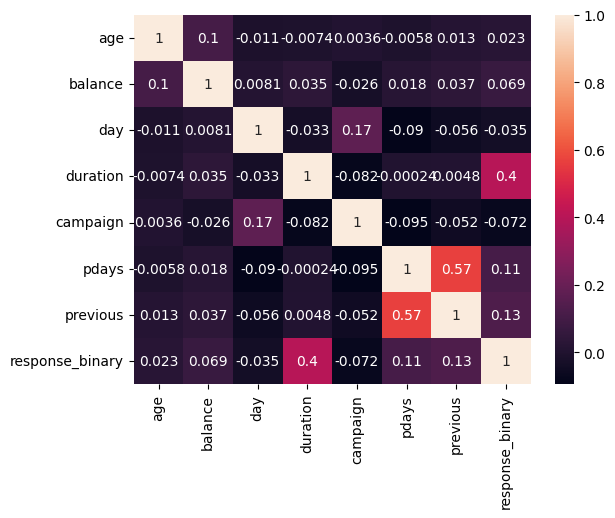

[('duration', 'response_binary', 0.40068142620731273), ('pdays', 'previous', 0.5677279001400981), ('previous', 'pdays', 0.5677279001400981), ('response_binary', 'duration', 0.40068142620731273)]


In [ ]:
df_corr=df[liste]
print(df_corr)
correlation=df_corr.corr()
print(correlation)
sns.heatmap(correlation,annot=True)
plt.show()
x,y=correlation.shape
list_corr=[(liste[k],liste[n],correlation.iloc[k,n]) for k in range(x) for n in range(y) if ((abs(correlation.iloc[k,n])>=0.4)& (k != n))]
print(list_corr)

**Lecture du dataset**

In [ ]:
features=df.drop("response", axis=1)
features = df[liste].values
targets=df["response_binary"].values
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32672, 8)
(8169, 8)
(32672,)
(8169,)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0 0 0 ... 0 0 0]
[1.32245704e-01 1.15754586e-01 5.39217395e-02 ... 1.28778621e-05
 7.62386508e-02 1.02248338e-03]


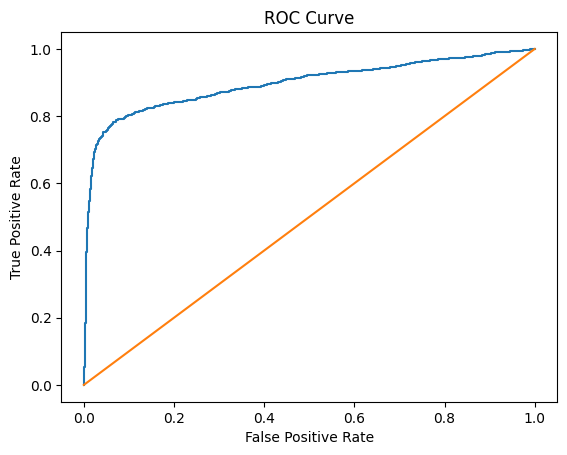

0.8960392058543876


In [ ]:
logreg=LogisticRegression(solver='lbfgs', max_iter=100)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
y_pred_proba=logreg.predict_proba(X_test)[:,1]
print(y_pred)
print(y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
roc_auc = auc(fpr, tpr)
print(roc_auc)

In [ ]:
features = df[feat]
features=pd.get_dummies(features,columns=one_hot_enconding,dtype=float, drop_first=True)
targets = df[cible]
targets=pd.get_dummies(targets,"response", drop_first=True,dtype=float)
features_train = features_train.select_dtypes(exclude=['object'])

In [ ]:
features.info()
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40841 entries, 0 to 40840
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       40841 non-null  int64  
 1   balance   40841 non-null  int64  
 2   duration  40841 non-null  float64
 3   campaign  40841 non-null  int64  
 4   pdays     40841 non-null  int64  
 5   loan_yes  40841 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 1.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40841 entries, 0 to 40840
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   response_yes  40841 non-null  float64
dtypes: float64(1)
memory usage: 319.2 KB


In [ ]:
features = sm.add_constant(features)

In [ ]:
features_train, features_test, targets_train, targets_test = train_test_split(features, targets,test_size=0.2, random_state=42)

In [ ]:
features_train.info()
targets_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32672 entries, 21394 to 15795
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   const     32672 non-null  float64
 1   age       32672 non-null  int64  
 2   balance   32672 non-null  int64  
 3   duration  32672 non-null  float64
 4   campaign  32672 non-null  int64  
 5   pdays     32672 non-null  int64  
 6   loan_yes  32672 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 2.0 MB
<class 'pandas.core.frame.DataFrame'>
Index: 32672 entries, 21394 to 15795
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   response_yes  32672 non-null  float64
dtypes: float64(1)
memory usage: 510.5 KB


In [ ]:
logit_model = sm.Logit(targets_train, features_train)

In [ ]:
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.280892
         Iterations 7


In [ ]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:           response_yes   No. Observations:                32672
Model:                          Logit   Df Residuals:                    32665
Method:                           MLE   Df Model:                            6
Date:                Sat, 24 Aug 2024   Pseudo R-squ.:                  0.1956
Time:                        15:03:20   Log-Likelihood:                -9177.3
converged:                       True   LL-Null:                       -11409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4275      0.085    -40.090      0.000      -3.595      -3.260
age            0.0064      0.002      3.564      0.000       0.003       0.010
balance     8.946e-05   1.01e-05      8.829      0.0

# Nouvelle section

# Nouvelle section